In [1]:
# Magic line to force reload all modules when this cell is run multiple times
# %load_ext autoreload
# %autoreload 2

import sys, os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
import numpy as np
import pandas as pd
import umap

from datetime import datetime
from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history, plot_3d_lrp
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(20,10),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [5]:
fname = "data/cleaned_SA.csv"
raw_data = pd.read_csv(fname, index_col=0)
raw_data.head()

,ASD_DX_group,Risk,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
103430,TYPICAL,HR,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,...,46.523426,88.635681,15.326110,268.573364,143.174347,1.515198,239.148468,20.107052,34.309757,10.180353
107524,ASD,HR,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
108372,TYPICAL,LR,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,...,35.009350,99.737000,23.199062,282.846497,29.161158,0.722310,200.596985,28.989164,32.400013,10.532928
113320,TYPICAL,LR,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,...,40.359753,111.341911,15.794782,214.678467,75.857338,1.767594,179.606552,16.667351,44.315159,12.016207
114640,TYPICAL,LR,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,...,49.686398,134.082794,18.534616,217.291306,36.213020,1.580427,181.796356,22.934441,63.739361,10.897783


In [6]:
raw_data.shape

(325, 335)

In [7]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = []

features = raw_data.drop(columns=noisy_cols+label_cols)
labels = raw_data[label_cols].copy()

In [8]:
labels["ASD_DX_group"][labels["Risk"]=="HR"].value_counts()

TYPICAL            149
ASD                 39
ATYPICAL_ADOS       17
ATYPICAL_MULLEN      9
Name: ASD_DX_group, dtype: int64

In [9]:
LR = labels["Risk"]=="LR"
typical = labels["ASD_DX_group"]=="TYPICAL"
ASD = labels["ASD_DX_group"]=="ASD"
HR = labels["Risk"]=="HR"

In [23]:
LR_typical = labels[LR & typical]
HR_typical = labels[HR & typical]
HR_ASD = labels[HR & ASD]

In [106]:
def build_dnn(num_features, num_labels, activation="elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    from keras.constraints import max_norm
    keras.backend.clear_session()
    
    tf.random.set_random_seed(RANDOM_STATE)
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)

    dnn.add(Dense(units = 64, activation=activation, input_dim = num_features,
                  kernel_initializer=he_init,  kernel_regularizer=my_reg))
    dnn.add(keras.layers.Dropout(0.2)),
    dnn.add(Dense(units = 64, activation=activation,
                  kernel_initializer=he_init,  kernel_regularizer=my_reg))
    dnn.add(keras.layers.Dropout(0.2))
    
    dnn.add(Dense(units=num_labels, activation="sigmoid",
                  kernel_initializer=he_init,  kernel_regularizer=my_reg)) # 5 labels -> logits for now
    
#     SGD=keras.optimizers.SGD(lr=0.001)
    NSGD = keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

# ASD vs LR_Typical

In [107]:
LR_analysis_labels = pd.concat((LR_typical, HR_ASD))
LR_analysis_labels["Risk"].value_counts()

LR    99
HR    39
Name: Risk, dtype: int64

In [108]:
enc = OrdinalEncoder()
enc.fit(LR_analysis_labels)
enc_labels = enc.transform(LR_analysis_labels)
enc.categories_

[array(['ASD', 'TYPICAL'], dtype=object), array(['HR', 'LR'], dtype=object)]

In [110]:
risk_labels = pd.Series(enc_labels[:,1], dtype=int, index=LR_analysis_labels.index)
data = features.loc[LR_analysis_labels.index].copy()

# Separating a hold out set that will be used for validation of the pipeline
# train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.01)
train_data, train_labels, test_data, test_labels = data, risk_labels, [], []

In [111]:
risk_labels.value_counts()

1    99
0    39
dtype: int64

In [112]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

In [115]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
LR_pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False)

Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.018, Acc:1.0000
Prediction Accuracy
14/14 [==============================] - 0s 3ms/step
Scores on data set: loss=1.384 accuracy=0.6429
Fold Correct: 9
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.018, Acc:1.0000
Prediction Accuracy
14/14 [==============================] - 0s 59us/step
Scores on data set: loss=1.214 accuracy=0.8571
Fold Correct: 12
Running worker: 2
Fold: 2 -> Loss:0.018, Acc:1.0000
Prediction Accuracy
14/14 [==============================] - 0s 36us/step
Scores on data set: loss=0.776 accuracy=0.7857
Fold Correct: 11
Running worker: 3
Fold: 3 -> Loss:0.018, Acc:1.0000
Prediction Accuracy
14/14 [==============================] - 0s 39us/step
Scores on data set: loss=1.295 accuracy=0.7143
Fold Correct: 10
Running worker: 4
Fold: 4 -> Loss:0.017, Acc:1.0000
Prediction Accuracy
14/14 [======

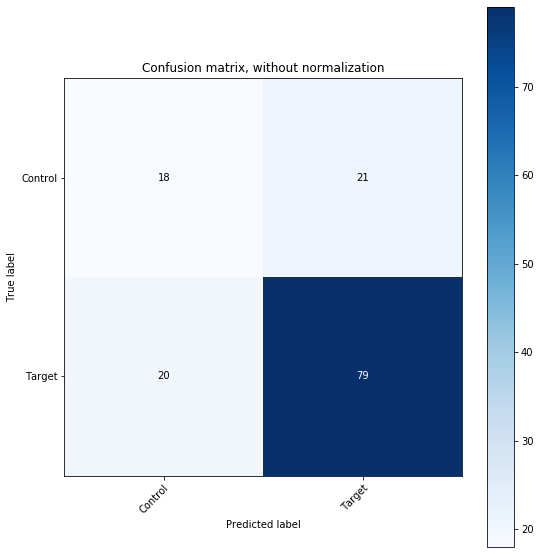

In [116]:
cm = LR_pipeline.train_model(batch_size=int(10), epochs=5000, cross_validation=True,
                          parallel=True, verbose=0, smote=True)

In [120]:
correct_ASD = cm[0][0]
print("Sensitivity: {:.4f}".format(correct_ASD/ np.sum(cm,axis=1)[0]))
print("PPV: {:.4f}".format(correct_ASD/ np.sum(cm,axis=0)[0]))

Sensitivity: 0.4615
PPV: 0.4737


In [127]:
LR_pipeline.train_clusterer()
print("Clusters Found:", max(LR_pipeline.clusterer.labels_)+1)

LRP Shape:  (18, 333)
Cluster Search Space: range(2, 8)
Minimum Size:
Clusters                  (5, 5)
Noise                     (2, 2)
Halkidi                   (2, 2)
Halkidi-Filtered Noise    (2, 2)
dtype: object
Clusters Found: 3


In [155]:
reindexed_labels = train_labels.iloc[LR_pipeline.testing_idxs]
correct_idxs = LR_pipeline.correct_preds_bool_arr
_correct = LR_analysis_labels.loc[reindexed_labels[correct_idxs].index]
LR_correct = _correct[_correct["ASD_DX_group"]=="ASD"]
LR_correct

,ASD_DX_group,Risk
CandID,,
172993,ASD,HR
402809,ASD,HR
930203,ASD,HR
983222,ASD,HR
809318,ASD,HR
812857,ASD,HR
456823,ASD,HR
490878,ASD,HR
751794,ASD,HR


In [154]:
# plot_3d_lrp(LR_pipeline.training_lrp, colors=LR_pipeline.clusterer.labels_)

# ASD vs HR_Typical

In [45]:
HR_analysis_labels = pd.concat((HR_typical, HR_ASD))
HR_analysis_labels["ASD_DX_group"].value_counts()

TYPICAL    149
ASD         39
Name: ASD_DX_group, dtype: int64

In [137]:
HR_enc = OrdinalEncoder()
HR_enc_labels = HR_enc.fit_transform(HR_analysis_labels)
HR_enc.categories_

[array(['ASD', 'TYPICAL'], dtype=object), array(['HR'], dtype=object)]

In [34]:
HR_risk_labels = pd.Series(enc_labels[:,0], dtype=int, index=analysis_labels.index)
data = features.loc[analysis_labels.index].copy()
train_data, train_labels, test_data, test_labels = data, HR_risk_labels, [], []
print(train_labels.shape)

(188,)


In [35]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

In [36]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
HR_pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False)

Running Pool...
Initialized Pool...
Runtime: 571.279s
Correct: 139
Test Size: 188
Confusion matrix, without normalization
[[0.33333333 0.66666667]
 [0.15436242 0.84563758]]
Overall Accuracy: 0.7394
Loading LRP Analyzers...
Done!


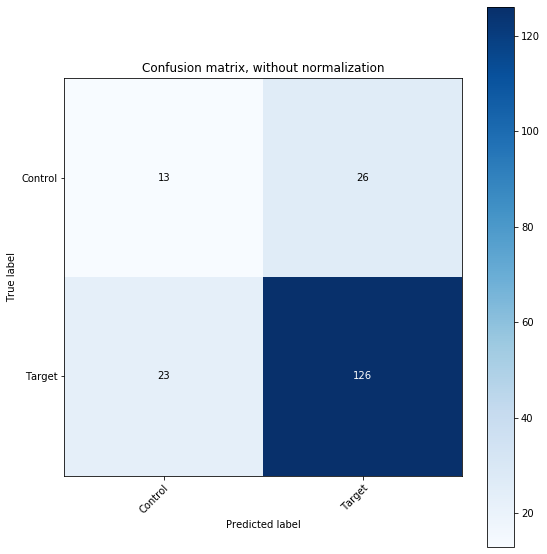

In [37]:
cm = pipeline.train_model(batch_size=int(10), epochs=5000, cross_validation=True,
                          parallel=True, verbose=0, smote=True)

In [38]:
correct_ASD = cm[0][0]
print("Sensitivity: {:.4f}".format(correct_ASD/ np.sum(cm,axis=1)[0]))
print("PPV: {:.4f}".format(correct_ASD/ np.sum(cm,axis=0)[0]))

Sensitivity: 0.3333
PPV: 0.3611


In [39]:
HR_pipeline=pipeline

In [40]:
HR_pipeline.train_clusterer()

LRP Shape:  (13, 333)
Cluster Search Space: range(2, 8)
Minimum Size:
Clusters                  (5, 5)
Noise                     (2, 2)
Halkidi                   (3, 3)
Halkidi-Filtered Noise    (3, 3)
dtype: object


(        Clusters     Noise       Halkidi  Halkidi-Filtered Noise
 (2, 2)         2  0.000000  1.097732e+00            1.097732e+00
 (3, 2)         2  0.000000  1.097732e+00            1.097732e+00
 (3, 3)         2  0.076923  3.710028e-01            1.053684e+00
 (4, 2)         2  0.000000  1.097732e+00            1.097732e+00
 (4, 3)         2  0.076923  3.710028e-01            1.053684e+00
 (4, 4)         2  0.076923  3.710028e-01            1.053684e+00
 (5, 2)         2  0.000000  1.097732e+00            1.097732e+00
 (5, 3)         2  0.076923  3.710028e-01            1.053684e+00
 (5, 4)         2  0.076923  3.710028e-01            1.053684e+00
 (5, 5)         0  1.000000  2.147484e+09            2.147484e+09
 (6, 2)         2  0.000000  1.097732e+00            1.097732e+00
 (6, 3)         2  0.076923  3.710028e-01            1.053684e+00
 (6, 4)         2  0.076923  3.710028e-01            1.053684e+00
 (6, 5)         0  1.000000  2.147484e+09            2.147484e+09
 (6, 6)   

In [138]:
HR_risk_labels = pd.Series(HR_enc_labels[:,0], dtype=int, index=HR_analysis_labels.index)

reindexed_labels = HR_risk_labels.iloc[HR_pipeline.testing_idxs]
correct_idxs = HR_pipeline.correct_preds_bool_arr
_correct = HR_analysis_labels.loc[reindexed_labels[correct_idxs].index]
HR_correct = _correct[_correct["ASD_DX_group"]=="ASD"]
HR_correct

,ASD_DX_group,Risk
CandID,,
172993,ASD,HR
983222,ASD,HR
809318,ASD,HR
321541,ASD,HR
490878,ASD,HR
751794,ASD,HR
174982,ASD,HR
589344,ASD,HR
155712,ASD,HR


In [153]:
# plot_3d_lrp(pipeline.training_lrp, colors=HR_pipeline.clusterer.labels_)

Cluster: 0
Size: 7
Cluster: 1
Size: 20


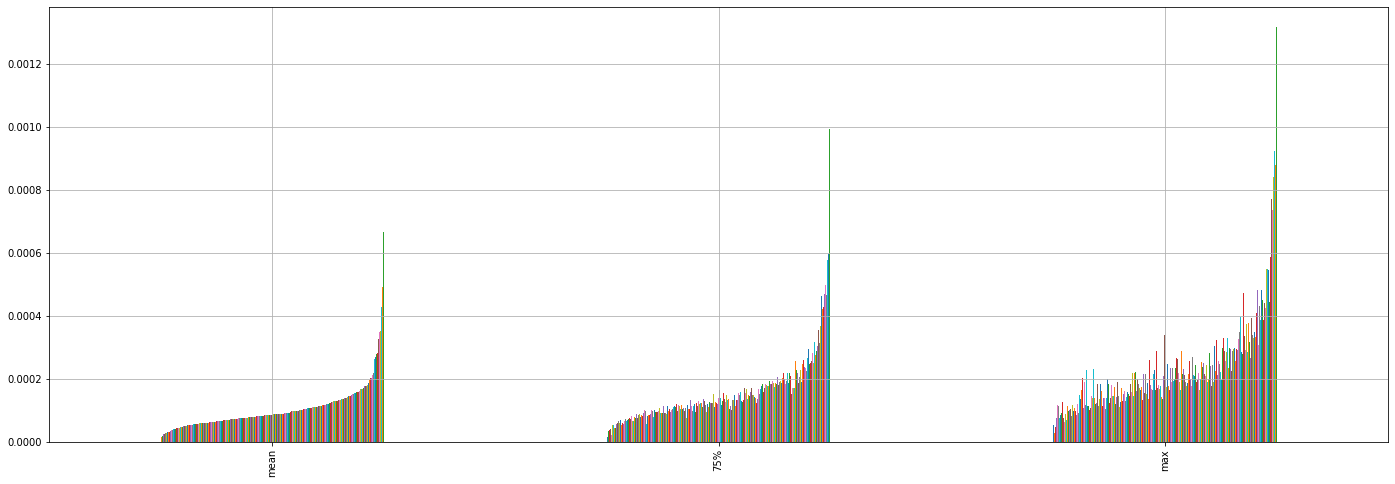

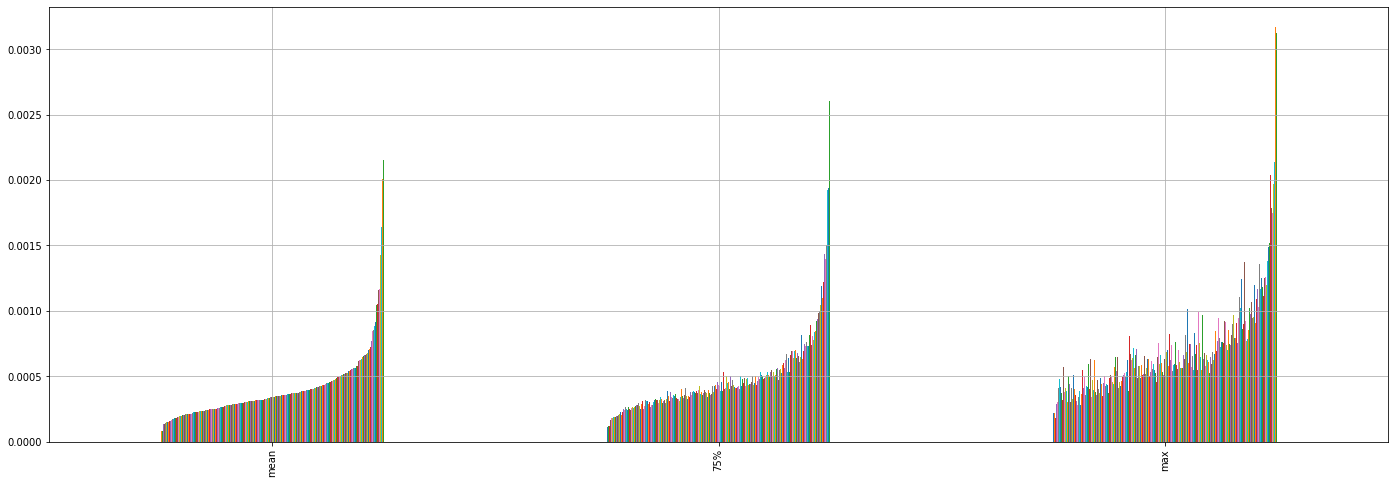

In [159]:
cluster_rels = {}
cluster_metrics = {}

for cluster_label in subcluster_labels:
    
    print("Cluster:", cluster_label)
    tsamples = target_class_features[(pipeline.clusterer.labels_ == cluster_label)]
    tlabels  = target_class_labels[(pipeline.clusterer.labels_ == cluster_label)]
    print("Size:", tlabels.shape[0])
    
    _clustered = pd.DataFrame(pipeline.training_lrp[(pipeline.clusterer.labels_ == cluster_label)],
                              columns = train_data.columns)
#   
    _metrics = _clustered.describe().loc[["mean","75%","max"]]
    srtd_metrics = _metrics.sort_values(by=["mean", "75%", "max"], axis=1)
    srtd_metrics.plot(kind="bar", figsize=(24,8), legend=False, grid=True)
    
    cluster_metrics[cluster_label] = _metrics.T
    cluster_rels[cluster_label] = _clustered

# Check sample IDs

In [232]:
HR_idx = HR_correct.index
LR_idx = LR_correct.index

common_idxs = HR_idx.intersection(LR_idx)
LR_lrp = pd.DataFrame(LR_pipeline.training_lrp[LR_correct.index.isin(common_idxs)], columns=train_data.columns)
HR_lrp = pd.DataFrame(HR_pipeline.training_lrp[HR_correct.index.isin(common_idxs)], columns=train_data.columns)

print(common_idxs.shape)
common_idxs

(11,)


Int64Index([172993, 983222, 809318, 490878, 751794, 174982, 589344, 155712,
            973338, 443584, 996243],
           dtype='int64', name='CandID')

> # Compare LRPs of patients common to BOTH n/ws

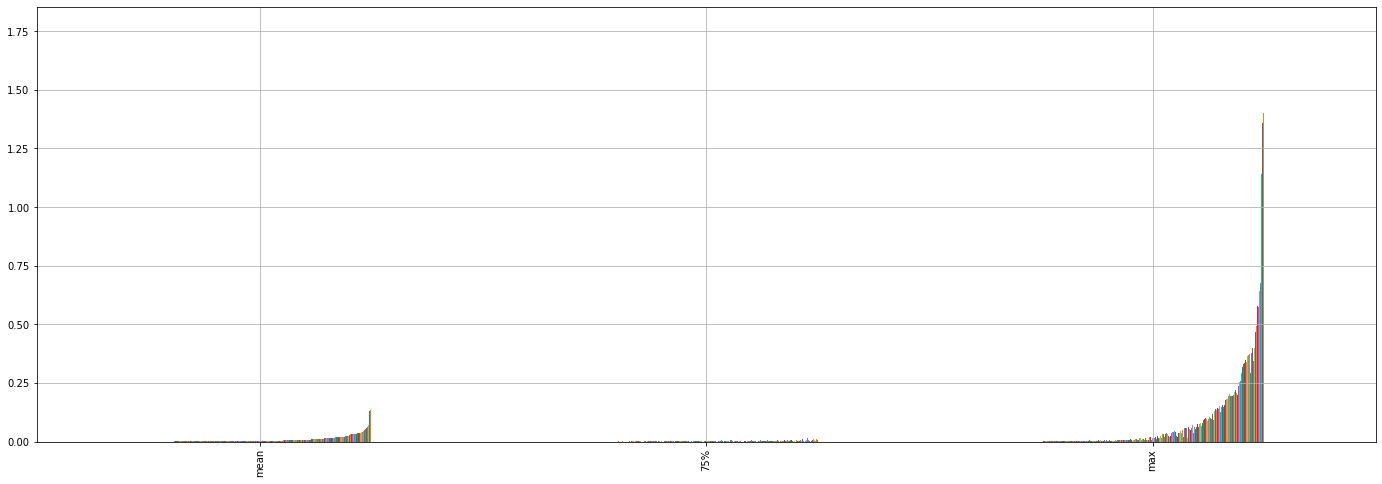

In [233]:
metrics_ = LR_lrp.describe().loc[["mean","75%","max"]]

srtd_metrics = metrics_.sort_values(by=["mean"], axis=1)
srtd_metrics.plot(kind="bar", figsize=(24,8), legend=False, grid=True)

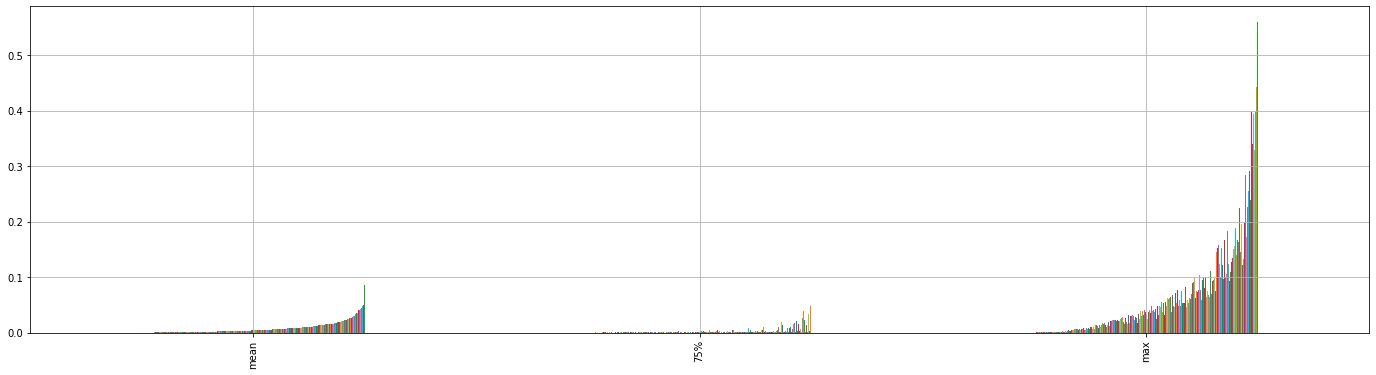

In [234]:
metrics_ = HR_lrp.describe().loc[["mean","75%","max"]]

srtd_metrics = metrics_.sort_values(by=["mean"], axis=1)
srtd_metrics.plot(kind="bar", figsize=(24,6), legend=False, grid=True)

In [235]:
# the most important features for at least (1-x)% of the samples
def plot_metrics(lrp_):
    thresh = 0.2

    metrics = [lrp_.mean(), lrp_.median(), lrp_.quantile(thresh)]

    for metric in metrics:
        _m = metric.sort_values(ascending=False)[:20]
        _m.plot(kind="bar", figsize=(24,8), legend=False, grid=True)
        plt.show()

In [236]:
# Get top-K features for the given metric
K = 10
metric_fn = lambda x: x.quantile(0.5).sort_values(ascending=False)[:K]

LR_lrp_metric = metric_fn(LR_lrp)
HR_lrp_metric = metric_fn(HR_lrp)

lrp_intersect = HR_lrp_metric.index.intersection(LR_lrp_metric.index)

print("Size:", lrp_intersect.shape[0])
lrp_intersect

Size: 5


Index(['ROI274', 'ROI197', 'ROI101', 'ROI38', 'ROI140'], dtype='object')

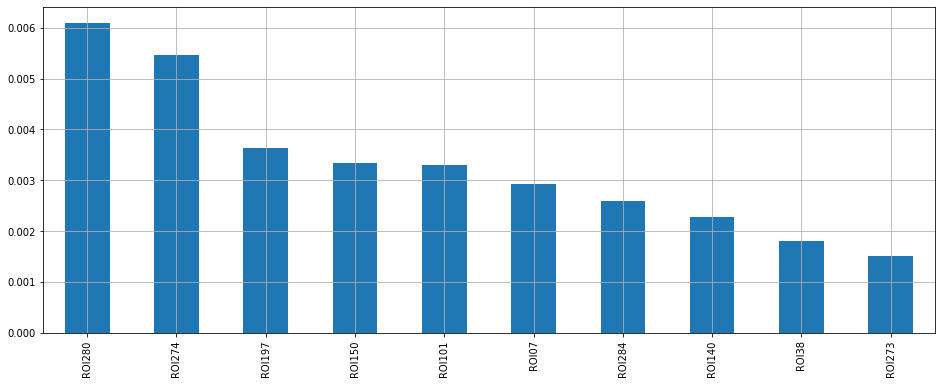

In [237]:
LR_lrp_metric.plot(kind="bar", figsize=(16,6), legend=False, grid=True)

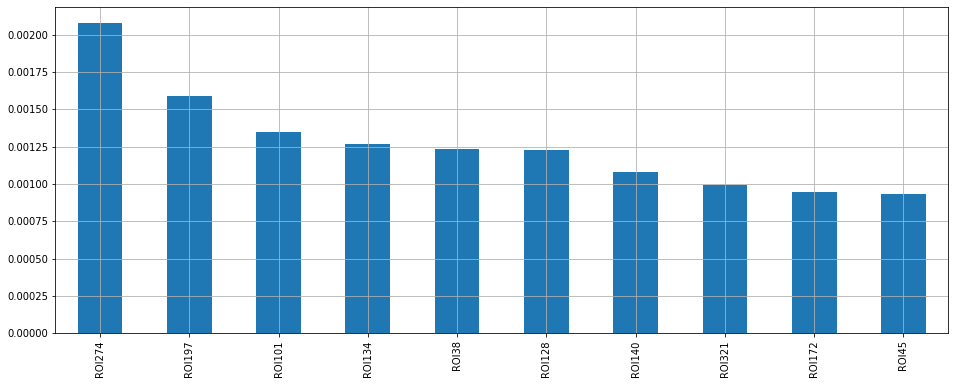

In [238]:
HR_lrp_metric.plot(kind="bar", figsize=(16,6), legend=False, grid=True)

# Other forms of aggregation??